# Readers

In [110]:
#| default_exp readers

In [111]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [113]:
#| export 

from copy import deepcopy
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import pylab as plt
from dataclasses import dataclass
from scipy.stats import linregress

import json
import gzip
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable
import os
from circadian.utils import *
import random
import difflib

import os
from scipy.ndimage import gaussian_filter1d
from os import read
pd.options.mode.chained_assignment = None

import glob
import os
import random
import difflib
from scipy.ndimage import gaussian_filter1d

from  jsonschema import validate
from fastcore.basics import *

In [114]:
#| exports

wearable_schema = {
    type: "object",
    "properties": {
            "steps": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "start": { "type": "number" },
                    "end": { "type": "number" },
                    "steps": { "type": "number" } } },
                "minItems": 1
            },
            "wake": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "start": { "type": "number" },
                    "end": { "type": "number" },
                    "wake": { "type": "number" } } }
            },
            "heartrate": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "timestamp": { "type": "number" },
                    "heartrate": { "type": "number" },
            } } },
    },
    "required": ["steps", "wake", "heartrate"]
}
    

In [115]:
test_wearable_data = {
    "steps": [ { "start": 0, "end": 1, "steps": 10 } ], 
    "heartrate": [ { "timestamp": 0, "heartrate": 10 } ],
    "wake": [ { "start": 0, "end": 1, "wake": 1.0} ]
}

validate(instance=test_wearable_data, schema=wearable_schema)


In [116]:
#| export


@dataclass
class WearableData:
    
    _dataframe: pd.DataFrame # the dataframe that holds the data must have date_time columns plus any other wearable streams from steps, heartrate, wake, light_estimate, activity
    phase_measure: np.ndarray = None
    phase_measure_times: np.ndarray = None
    subject_id: str = "unknown-subject"
    data_id: str = "unknown-data-id"
    
    @property
    def date_time(self) -> np.ndarray:
        return self._dataframe["date_time"].values
    
    @property
    def time_total(self) -> np.ndarray:
        return self._dataframe["time_total"].values
    
    @property
    def light_estimate(self) -> np.ndarray:
        if 'light_estimate' in self._dataframe.columns:
            return self._dataframe["light_estimate"].values
        if 'steps' in self._dataframe.columns:
            return self._dataframe["steps"].values
        if 'activity' in self._dataframe.columns:
            return self._dataframe["activity"].values
        return np.ones_like(self.time_total)*np.nan
    
    @property
    def steps(self) -> np.ndarray:
        if 'steps' in self._dataframe.columns:
            return self._dataframe["steps"].values
        else:
            return np.ones_like(self.time_total)*np.nan
    
    @property
    def activity(self) -> np.ndarray:
        if 'activity' in self._dataframe.columns:
            return self._dataframe["activity"].values
        else:
            return np.ones_like(self.time_total)*np.nan
    
    @property
    def heartrate(self) -> np.ndarray:
        if 'heartrate' in self._dataframe.columns:
            return self._dataframe["heartrate"].values
        else:
            return np.ones_like(self.time_total)*np.nan # generate a nan array
    
    @property
    def wake(self) -> np.ndarray:
        if 'wake' in self._dataframe.columns:
            return self._dataframe["wake"].values
        else:
            return np.ones_like(self.time_total)*np.nan # generate a nan array
        
    @property
    def time_hour_bounds(self) -> Tuple[float, float]:
        return (self.time_total[0], self.time_total[-1])
    
    @property
    def date_bounds(self) -> Tuple[datetime, datetime]:
        start_date = pd.to_datetime(self.date_time[0], unit='s')
        end_date = pd.to_datetime(self.date_time[-1], unit='s')
        return (start_date, end_date)
    
    @staticmethod
    def utc_to_hrs(d: datetime):
        return d.hour+d.minute/60.0+d.second/3600.0

    def __post_init__(self):
        # Check that we have the required columns
        assert "date_time" in self._dataframe.columns
        assert "time_total" in self._dataframe.columns


    def build_sleep_chunks(self, chunk_jump_hrs: float = 12.0) -> List[np.ndarray]:

        time_total = self.time_total
        steps = self.steps
        heartrate = self.heartrate
        wake = self.wake
        data = np.stack((steps, heartrate, wake), axis=0)
        j_idx = np.where(np.diff(time_total) > chunk_jump_hrs)[0]
        return np.split(data, j_idx, axis=1)

    def get_date(self, time_hr: float):
        idx = np.argmin(np.abs(np.array(self.time_total) - time_hr))
        return pd.to_datetime(self.date_time[idx], unit='s')

    def get_timestamp(self, time_hr: float):
        idx = np.argmin(np.abs(np.array(np.hstack(self.time_total)) - time_hr))
        return np.hstack(self.date_time)[idx]

    def trim_by_idx(self, 
                    idx1: int, # First index to keep
                    idx2: int = None # second idx should be greater than idx1, defaults to the last value
                    ) -> 'WearableData':
        df = self._dataframe.loc[idx1:idx2, :]
        return WearableData(df, 
                            self.subject_id, 
                            self.data_id, 
                            self.phase_measure,
                            self.phase_measure_times)

    def trim_by_hour(self, hour_start: float, hour_end: float) -> 'WearableData':
        # Trim the __dateframe to be within the interval [t1,t2]
        df = self._dataframe[self._dataframe.time_total.between(hour_start, hour_end, inclusive=True), :]
        return WearableData(df, 
                            self.subject_id, 
                            self.data_id, 
                            self.phase_measure, 
                            self.phase_measure_times)

    def scaled_light_estimate(self, multiplier: float = 1.0) -> np.ndarray:
        return multiplier*self.light_estimate

    def to_json(self, filename: str = None):
        filename = filename if filename is not None else 'wearable_' + self.subject_id + '.json'
        self._dataframe.to_json(filename)
        
    def from_json(filename: str) -> 'WearableData':
        df = pd.read_json(filename)
        return WearableData(df)


In [117]:
#| export

@patch 
def steps_hr_loglinear(self: WearableData
                       ) -> Tuple[float, float]:
        """
        Find the log steps to hr linear regression parameters .
        hr=beta*log(steps+1.0)+alpha
        Returns beta,alpha
        """
        x = np.log(np.hstack(self.steps)+1.0)
        y = np.hstack(self.heartrate)
        x = x[y > 0]
        y = y[y > 0]
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        return slope, intercept

Make a routine to plot the available heartrate data.

In [118]:
#| export

@patch
def plot_heartrate(self: WearableData, 
                   t1=None, 
                   t2=None, 
                   *args, 
                   **kwargs):

        time_start = t1 if t1 is not None else self.time_total[0]
        time_end = t2 if t2 is not None else self.time_total[-1]

        hr = deepcopy(self.heartrate)
        hr[hr == 0] = np.nan
        fig = plt.figure()
        ax = plt.gca()

        ax.plot(self.time_total / 24.0, hr, color='red', *args, **kwargs)
        ax.set_xlabel('Days')
        ax.set_ylabel('BPM')
        ax.set_title('Heart Rate Data')
        ax.set_ylim((0, 220))
        plt.show()

In [119]:
#| export

@patch
def scatter_hr_steps(self: WearableData, 
                     take_log: bool = True, # Log transform the data?
                     *args, 
                     **kwargs):
    
        fig = plt.figure()
        ax = plt.gca()

        steps = np.hstack(self.steps)
        heartrate = np.hstack(self.heartrate)

        if take_log:
            ax.scatter(np.log10(steps[heartrate > 0]+1.0),
                       np.log10(heartrate[heartrate > 0]),
                       color='red',
                       *args,
                       **kwargs)
        else:
            ax.scatter(steps[heartrate > 0], heartrate[heartrate > 0],
                       color='red',
                       *args,
                       **kwargs)

        ax.set_ylabel('BPM')
        ax.set_xlabel('Steps')
        ax.set_title('Heart Rate Data')
        plt.show()

In [135]:
#| export

@patch
def plot_hr_steps(self: WearableData, 
                  t1: float = None, 
                  t2: float = None, 
                  *args, 
                  **kwargs):

        time_start = t1 if t1 is not None else self.time_total[0]/24.0
        time_end = t2 if t2 is not None else self.time_total[-1]/24.0

        fig = plt.figure()
        gs = fig.add_gridspec(2, hspace=0.0)
        ax = gs.subplots(sharex=True)
        fig.suptitle(
            f"{self.data_id} Wearable Data: Subject {self.subject_id}")
        hr_all_nan = np.all(np.isnan(self.heartrate))
        if not hr_all_nan:
            ax[0].plot(self.time_total / 24.0, 
                       self.heartrate, 
                       color='red', 
                       *args, 
                       **kwargs)
            
        ax[1].plot(self.time_total / 24.0, 
                   self.steps,
                   color='darkgreen', 
                   *args, 
                   **kwargs)

        sleep_all_nan = np.all(np.isnan(self.wake))
        if not sleep_all_nan:
            ax[1].plot(self.time_total / 24.0, np.array(self.wake) *
                       max(np.median(self.steps), 50.0), color='k')

        if self.phase_measure_times is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]

        ax[1].set_xlabel("Days")
        ax[0].set_ylabel("BPM")
        ax[1].set_ylabel("Steps")
        ax[0].grid()
        ax[1].grid()
        ax[0].set_xlim((time_start, time_end))
        ax[1].set_xlim((time_start, time_end+3.0))
        ax[0].set_ylim((0, 200))
        plt.show()


# Reading Wearable Data

The standard json should take the following format:

```{json}
        { 
            "steps": [ { "start": 1234567890, "end": 1234567895, "steps": 1234 }, ... ],
            "heartrate": [ { "timestamp": 1234567890, "heartrate": 123 }, ... ],
            "wake": [ { "start": 1234567890, "end": 1234567895, "wake": 1.0 }, ... ],
        }
```
        
The JSON can have other keys as well, but to be properly parsed, this format should be used. 
The steps key is the only required key, the others are optional.

The wake key have a value of 1.0 if the user was awake, and 0.0 if the user was asleep. 

Dates are in unix time, and should be in seconds.

In [136]:
#| export

def combine_wearable_streams(steps: pd.DataFrame, 
                                heartrate: pd.DataFrame,
                                wake: pd.DataFrame,
                                bin_minutes: int = 6,
                                subject_id: str="unknown-subject",
                                data_id: str ="Exporter",
                                sleep_trim: bool = False, # drop any entries without a sleep-wake entry
                                inner_join: bool = False # if true, only keep entries that have both heartrate and sleep data
                                ) -> WearableData:
    
    # Convert unix times to datetime
    steps['start'] = pd.to_datetime(steps.start, unit='s')
    steps['end'] = pd.to_datetime(steps.end, unit='s')
    wake['start'] = pd.to_datetime(wake.start, unit='s')
    wake['end'] = pd.to_datetime(wake.end, unit='s')
    heartrate['timestamp'] = pd.to_datetime(heartrate.timestamp, unit='s')
    
    # Resample the steps to the desired bin size
    s1 = steps.loc[:, ['start', 'steps']]
    s2 = steps.loc[:, ['end', 'steps']]
    s1.rename(columns={'start': 'timestamp'}, inplace=True)
    s2.rename(columns={'end': 'timestamp'}, inplace=True)
    steps = pd.concat([s1, s2])
    steps.set_index('timestamp', inplace=True)
    steps = steps.resample(str(int(bin_minutes)) +
                            'Min').agg({'steps': 'sum'})
    steps.reset_index(inplace=True)
    
    # Resample the heartrate data to the desired bin size
    heartrate.set_index('timestamp', inplace=True)
    heartrate = heartrate.resample(
        str(int(bin_minutes))+'Min').agg({'heartrate': 'max'})
    heartrate.reset_index(inplace=True)

    # Merge the steps and heartrate data and fill missing heartrate with zeros
    merge_method = 'inner' if inner_join else 'left'
    df = pd.merge(steps, heartrate, on='timestamp', how=merge_method)
    
    # Resample the wake data to the desired bin size
    s1 = wake.loc[:, ['start', 'wake']]
    s2 = wake.loc[:, ['end', 'wake']]
    s1.rename(columns={'start': 'timestamp'}, inplace=True)
    s2.rename(columns={'end': 'timestamp'}, inplace=True)
    wake = pd.concat([s1, s2])
    wake.set_index('timestamp', inplace=True)
    wake = wake.resample(str(int(bin_minutes)) +
                            'Min').agg({'wake': 'max'})
    wake.reset_index(inplace=True)
    
    merge_method = 'inner' if inner_join else 'left'
    df = pd.merge(df, wake, on='timestamp', how=merge_method)
    
    # Make the timestamp column actually be a unix timestamp
    df['date_time'] = (
        df['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
    time_start = WearableData.utc_to_hrs(df.timestamp.iloc[0])
    df['time_total'] = time_start + (df.date_time-df.date_time.iloc[0])/3600.0
    
    aw = WearableData(_dataframe=df,
                    subject_id=subject_id,
                    data_id=data_id
                    )

    return aw
    

def read_standard_csv(directory_path: str, # path to the directory containing the csv files
                        bin_minutes: int = 6,
                        subject_id="unknown-subject",
                        data_id="Exporter",
                        sleep_trim: bool = False, # drop any entries without a sleep-wake entry
                        inner_join: bool = False # if true, only keep entries that have both heartrate and sleep data
                        ) -> WearableData:

    steps = pd.read_csv(directory_path+"/steps.csv", columns=['start', 'end', 'steps'])
    heartrate = pd.read_csv(directory_path+"/heartrate.csv", columns=['timestamp', 'heartrate'])
    wake = pd.read_csv(directory_path+"/sleep.csv", columns=['start', 'end', 'wake'])
    
    return combine_wearable_streams(steps, heartrate, wake, bin_minutes, subject_id, data_id, sleep_trim, inner_join)

        

def read_standard_json( filepath: str, # path to json file
                        bin_minutes: int = 6, # data will be binned to this resolution in minutes
                        subject_id: str ="unknown-subject", #subject id to be used
                        data_id: str = "Exporter", # name of the data source
                        gzip_opt: bool = False, # set to true if the file is gzipped, will be autodetected if extension is .gz
                        sleep_trim: bool = False, # drop any entries without a sleep-wake entry
                        inner_join: bool = False # if true, only keep entries that have both heartrate and sleep data
                        ) -> WearableData:
    gzip_opt = gzip_opt if gzip_opt else filepath.endswith(".gz")
    fileobj = gzip.open(filepath, 'r') if gzip_opt else open(filepath, 'r')
    rawJson = json.load(fileobj)
    validate(rawJson, wearable_schema)
    
    steps = pd.DataFrame(rawJson['steps'], columns=["start", "end", "steps"])
    # These could be empty
    wake = pd.DataFrame(rawJson['wake'], columns=["start", "end", "wake"]) 
    heartrate = pd.DataFrame(rawJson['heartrate'], columns=["timestamp", "heartrate"])
    
    return combine_wearable_streams(steps, heartrate, wake, bin_minutes, subject_id, data_id, sleep_trim, inner_join)
        
        


In [137]:
@patch 
def fill_nan_heartrate(self: WearableData, with_value: float = 0.0):
    """Fill in any nan values in the heartrate data using the specified method"""
    self.heartrate = pd.Series(self.heartrate).fillna(with_value).to_numpy()

In [138]:

sample_data = read_standard_json(filepath="/Users/khannay/data/WearableData/LongTermUnlabeled/exporter/memAllData_converted.json", subject_id="mem")



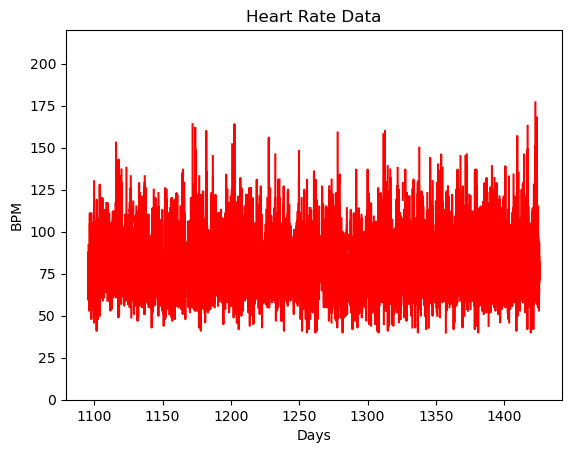

In [139]:
sample_data.plot_heartrate()

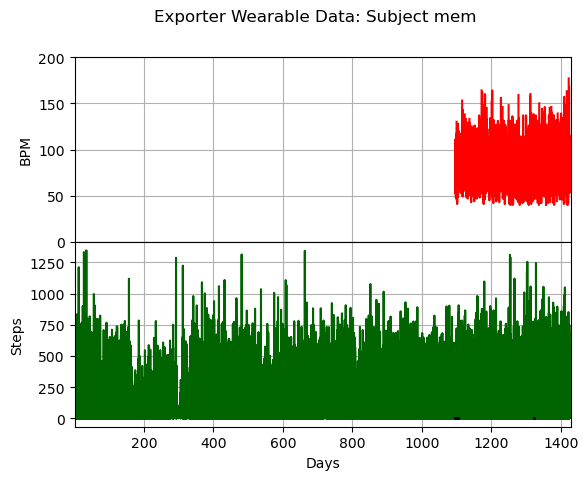

In [140]:
sample_data.plot_hr_steps()

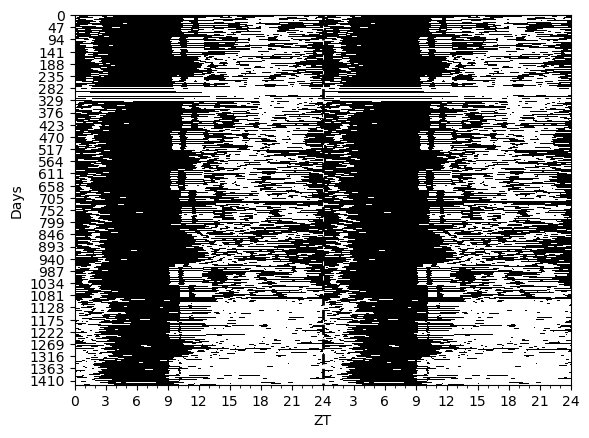

In [147]:
from circadian.plots import Actogram 
Actogram(sample_data.time_total, sample_data.steps);

In [ ]:
#| export

@patch 
def plot_light_activity(self: WearableData, 
                        show=True, 
                        vlines=None, 
                        *args, **kwargs):

        fig = plt.figure()
        gs = fig.add_gridspec(2, hspace=0)
        ax = gs.subplots(sharex=True)
        fig.suptitle(
            f"{self.data_id} Subject {self.subject_id}")
        ax[0].plot(self.time_total / 24.0, np.log10(self.light_estimate+1.0), color='red')
        ax[1].plot(self.time_total / 24.0, self.activity, color='darkgreen')
        
        try:
            ax[1].plot(self.time_total / 24.0, self.wake *
                       np.median(self.steps), color='k')
        except:
            print(f"Error with wake plot with {self.subject_id}")

        if self.phase_measure_times is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]

        if vlines is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='cyan')
             for _x in vlines]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='cyan')
             for _x in vlines]

        ax[1].set_xlabel("Days")
        ax[0].set_ylabel("Lux (log 10)")
        ax[1].set_ylabel("Activity Counts")
        ax[0].grid()
        ax[1].grid()
        if show:
            plt.show()
        else:
            return ax


## Actiwatch Readers 

In [ ]:
#| export

def read_actiwatch(filepath: str,
                        MIN_LIGHT_THRESHOLD=5000,
                        round_data=True,
                        bin_minutes=6,
                        dt_format: str = "%m/%d/%Y %I:%M:%S %p"
                        ) -> WearableData:
    """
        Takes in a csv with columns 
            Date : str 
            Time : str 
            White Light: float 
            Sleep/Wake: float 
            Activity: float
        returns a WearableData object
    """
    df = pd.read_csv(filepath)
    df['DateTime'] = df['Date']+" "+df['Time']
    df['DateTime'] = pd.to_datetime(
        df.DateTime, format=dt_format)

    df['UnixTime'] = (
        df['DateTime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df['Lux'] = df['White Light']
    df.rename(columns={'Sleep/Wake': 'Wake'}, inplace=True)

    df['Lux'].fillna(0, inplace=True)
    df['LightSum'] = np.cumsum(df.Lux.values)
    df['LightSumReverse'] = np.sum(
        df.Lux.values) - np.cumsum(df.Lux.values) + 1.0

    df = df[(df.LightSum > MIN_LIGHT_THRESHOLD) & (
        df.LightSumReverse > MIN_LIGHT_THRESHOLD)]

    time_start = self.utc_to_hrs(df.DateTime.iloc[0])
    df2 = df[['UnixTime']].copy(deep=True)
    base_unix_time = df2['UnixTime'].iloc[0]
    df['TimeTotal'] = time_start + \
        (df2.loc[:, ['UnixTime']]-base_unix_time)/3600.0

    df = df[["DateTime", "TimeTotal", "UnixTime", "Activity", "Lux", "Wake"]]
    if round_data:
        df.set_index('DateTime', inplace=True)
        df = df.resample(str(int(bin_minutes))+'Min').agg({'TimeTotal': 'min',
                                                            'UnixTime': 'min',
                                                            'Activity': 'sum',
                                                            'Lux': 'median',
                                                            'Wake': 'max'})
        df.reset_index(inplace=True)

    # # Not sure why hchs needs this
    # df['TimeTotal'].interpolate(inplace=True)
    #df.fillna(0, inplace=True)
    return WearableData(
        date_time=df.DateTime.values.to_numpy(),
        time_total=df.TimeTotal.values.to_numpy(),
        light_estimate=df.Lux.values.to_numpy(),
        activity=df.Activity.values.to_numpy(),
    )


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()